In [14]:
# Import required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import re

In [15]:
# Set format for tables in the notebook

pd.set_option('max_rows', 8)
pd.set_option('display.max_colwidth', 500)
styling_tables = [{'selector': 'th', 'props': [("text-align", "center"), ('background-color', '#b59d9b'), 
                                                      ('color', '#3d0909'), ('border', '0.8px solid #3d0909')]},
                        {'selector': 'td', 'props': [("text-align", "center"), ('background-color', '#f1f1f1'), 
                                                      ('border', '0.8px solid #3d0909'), ('color', '#3d0909'),
                                                    ('width', '300px'), ('precision', '2')]},
                        {'selector': 'caption', 'props': [("text-align", "center"), ('color', '#3d0909'), 
                                                          ('font-size', '14px'), ('font-weight', 'bold'), 
                                                          ('color', '#3d0909')]},
                 {'selector': 'table', 'props': [('ilign', 'center')]}]

In [16]:
# Import training set of the Titanic dataset 

dataset = pd.read_csv('train.csv')

In [17]:
# Check the the sets size

set_size = dataset.shape

print('Set size:', set_size)

Set size: (100000, 12)


In [18]:
# Display the dataset to get grasp of the data

styler = dataset.head(7).style
styler.set_caption('Original Titanic Dataset')
styler.set_table_styles(styling_tables)
styler.highlight_null(props = 'color : red; font-weight : bold')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,nan,2,0,209245,27.140000,C12239,S
1,1,0,3,"Bryan, Drew",male,nan,0,0,27323,13.350000,nan,S
2,2,0,3,"Owens, Kenneth",male,0.330000,1,2,CA 457703,71.290000,nan,S
3,3,0,3,"Kramer, James",male,19.000000,0,0,A. 10866,13.040000,nan,S
4,4,1,3,"Bond, Michael",male,25.000000,0,0,427635,7.760000,nan,S
5,5,0,2,"Sassano, Jonathan",male,35.000000,0,0,13363,6.710000,nan,S
6,6,0,3,"Conway, Jose",male,7.000000,0,0,A/5,9.770000,nan,S


In [19]:
# Passenger ID is obviously redundant column, which can be converted to index. Also, rename the index for brevity.

dataset.set_index('PassengerId', inplace = True)
dataset.rename_axis('ID', inplace = True)

In [20]:
# Original column names are not quite clear. Remane the column to give people instant insight into the data

dataset.rename(columns = {'Pclass': 'Ticket class', 'SibSp': 'Siblings/spouses',
                       'Parch': 'Parents/children'}, inplace = True)

In [21]:
# Split name column into first name and surname to be able to find the families onboard

dataset['First name'] = dataset['Name'].apply(lambda s: s.split(', ')[1])
dataset['Surname'] = dataset['Name'].apply(lambda s: s.split(', ')[0])
dataset.drop(columns = 'Name', inplace = True)

In [22]:
# It can be noticed that cabin number has alphabetic prefix, which could be correspondent with ticket class
# Extract cabin class as a separate variable

dataset['Cabin class'] = dataset['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else np.nan)
dataset['Cabin number'] = dataset['Cabin'].apply(lambda s: s[1:] if pd.notnull(s) else np.nan)
dataset.drop(columns = ['Cabin'], inplace = True)

In [23]:
# Display modified dataset

styler = dataset.head(7).style
styler.set_caption('Modified Titanic Dataset')
styler.set_table_styles(styling_tables)

,Survived,Ticket class,Sex,Age,Siblings/spouses,Parents/children,Ticket,Fare,Embarked,First name,Surname,Cabin class,Cabin number
ID,,,,,,,,,,,,,
0,1,1,male,nan,2,0,209245,27.140000,S,Frankie,Oconnor,C,12239
1,0,3,male,nan,0,0,27323,13.350000,S,Drew,Bryan,nan,nan
2,0,3,male,0.330000,1,2,CA 457703,71.290000,S,Kenneth,Owens,nan,nan
3,0,3,male,19.000000,0,0,A. 10866,13.040000,S,James,Kramer,nan,nan
4,1,3,male,25.000000,0,0,427635,7.760000,S,Michael,Bond,nan,nan
5,0,2,male,35.000000,0,0,13363,6.710000,S,Jonathan,Sassano,nan,nan
6,0,3,male,7.000000,0,0,A/5,9.770000,S,Jose,Conway,nan,nan


In [24]:
# Get quick insight into columns data types and number of missing values

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Survived          100000 non-null  int64  
 1   Ticket class      100000 non-null  int64  
 2   Sex               100000 non-null  object 
 3   Age               96708 non-null   float64
 4   Siblings/spouses  100000 non-null  int64  
 5   Parents/children  100000 non-null  int64  
 6   Ticket            95377 non-null   object 
 7   Fare              99866 non-null   float64
 8   Embarked          99750 non-null   object 
 9   First name        100000 non-null  object 
 10  Surname           100000 non-null  object 
 11  Cabin class       32134 non-null   object 
 12  Cabin number      32134 non-null   object 
dtypes: float64(2), int64(4), object(7)
memory usage: 10.7+ MB


In [25]:
# Let`s look at non-numeric data

non_numeric_data = dataset.select_dtypes(include = 'object').join(dataset[['Ticket class', 'Survived']])

unique_n = non_numeric_data.apply(lambda col: len(col.unique()))

instances_n = 9
instances = non_numeric_data.apply(lambda col: col.unique() if len(col.unique()) <= instances_n 
                                   else random.choices(col.unique(), k = 5))

nan_n = non_numeric_data.apply(lambda col: col.isna().sum())

non_numeric_info = pd.DataFrame({'Number of unique values': unique_n, 'Instances of vabiable': instances, 
                                 'Number of nan values': nan_n})

styler3 = non_numeric_info.style
styler3.set_caption('Information on non-numeric data of the Titanic dataset - Raw data')
styler3.set_table_styles(styling_tables)

,Number of unique values,Instances of vabiable,Number of nan values
Sex,2,['male' 'female'],0
Ticket,75332,"['STON/O 3746890', '361101', '438175', '463388', 'W./C. 6856']",4623
Embarked,4,['S' 'C' 'Q' nan],250
First name,3953,"['Elmer', 'Tyree', 'Janay', 'Emilee', 'Coleen']",0
Surname,21558,"['Bos', 'Lacroix', 'Pender', 'Gunter', 'Dollar']",0
Cabin class,9,['C' nan 'A' 'D' 'B' 'E' 'F' 'G' 'T'],67866
Cabin number,16571,"['7985', '17690', '20058', '10759', '17182']",67866
Ticket class,3,[1 3 2],0
Survived,2,[1 0],0


In [26]:
# Convert variables 'Sex', 'Embarked', 'Cabin class' into categorical values

categorical = ['Sex', 'Embarked', 'Cabin class', 'Ticket class', 'Survived']
dataset[categorical] = dataset[categorical].astype('category')

In [27]:
# Let`s look at numeric data

numeric_data = dataset.select_dtypes(include = ['int64', 'float64'])

maximum = numeric_data.apply(lambda col: col.max())
minimum = numeric_data.apply(lambda col: col.min())
mean = numeric_data.apply(lambda col: col.mean())
std = numeric_data.apply(lambda col: col.std())
nan_n = numeric_data.apply(lambda col: col.isna().sum())

outlier_n = []
for i in range(numeric_data.shape[1]):
    outlier_n.append(len(numeric_data[numeric_data.iloc[:, i] < (mean[i] - 3 * std[i])]) 
                    + len(numeric_data[numeric_data.iloc[:, i] > (mean[i] + 3 * std[i])]))

numeric_info = pd.DataFrame({'Minimum value': minimum, 'Maximum value': maximum, 'Mean value': mean, 'Standad deviation': std,
                            'Number of nan values': nan_n, 'Number of outliers': outlier_n})

styler4 = numeric_info.style
styler4.set_caption('Information on numeric data of the Titanic dataset - Raw data')
styler4.set_table_styles(styling_tables)

,Minimum value,Maximum value,Mean value,Standad deviation,Number of nan values,Number of outliers
Age,0.080000,87.000000,38.355472,18.313556,3292,0
Siblings/spouses,0.000000,8.000000,0.397690,0.862566,0,3231
Parents/children,0.000000,9.000000,0.454560,0.950076,0,1245
Fare,0.680000,744.660000,43.929330,69.588820,134,2339


In [28]:
# Convert variables 'Siblings/spouses' and 'Parens/children' into integer type variables

integers = ['Siblings/spouses', 'Parents/children']
dataset[integers] = dataset[integers].astype('int64')

In [29]:
# Analyse the column 'Age'. Check if there are fractional numbers. It is more reasonable to express age as an integer

non_integers = dataset['Age'].dropna()[dataset['Age'] % 1 != 0]

dataset['Age'] = dataset['Age'].apply(lambda v: int(v) if pd.notna(v) else np.nan)

print('There are {} non-integers in "Age" column, which will be converted to integers.\n'.format(len(non_integers)))
print('Some of the fractional ages currently present in the dataset:')

non_integers.head()

There are 1139 non-integers in "Age" column, which will be converted to integers.

Some of the fractional ages currently present in the dataset:


ID
2       0.33
215     0.83
228     0.50
247    24.50
415     0.75
Name: Age, dtype: float64

In [30]:
# The above values that lower than 1 can indicate the infants, otherwise they are erroneous.
# To check whether these values are indeed infants, check if they have parents onboard. Infants can't travel by themselves.

zeros = dataset[dataset['Age'] == 0]
not_infants = dataset[(dataset['Parents/children'] == 0) & (dataset['Age'] == 0)]

print('Out of {} zero age values {} values relate to udult peeople. Remaining {} values are indeed infants.'
      .format(len(zeros), len(not_infants), len(zeros) - len(not_infants)))

Out of 642 zero age values 94 values relate to udult peeople. Remaining 548 values are indeed infants.


In [31]:
# Replace zero age values related to adults with random values in range of one standard deviation of the age distribution

mean = int(dataset['Age'].mean()) 
std = int(dataset['Age'].std())

for v in dataset['Age'][(dataset['Parents/children'] == 0) & (dataset['Age'] == 0)]:
    v = random.randint(mean - std, mean + std)
    
# Replace nan values with random values in range of one standard deviation of the age distribution

dataset['Age'].fillna(random.randint(mean - std, mean + std), inplace = True)

In [32]:
# Divide people into groups based on their ages

age_ranges = list(range(0, int(dataset['Age'].max()), 6))

age_number = []
for i in range(len(age_ranges) - 1):
    age_number.append(len(dataset[(dataset['Age'] >= age_ranges[i]) & (dataset['Age'] < age_ranges[i + 1])]))
    
ranges = []
for i in range(len(age_ranges) - 1):  
    ranges.append(str(age_ranges[i]) + '-' + str(age_ranges[i + 1]))

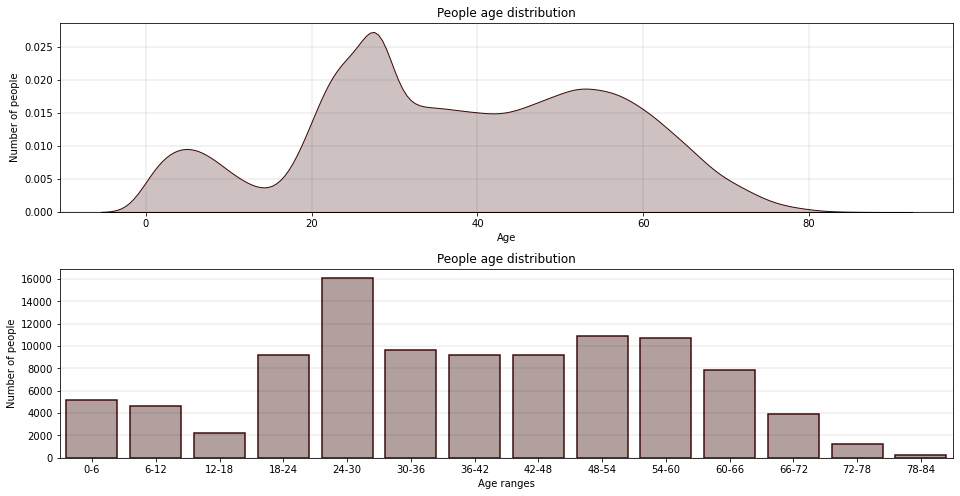

The plot shows that people of age 18 - 24 years old is the largest group onboard.
Whereas, people of age 78 - 84 years old is the smallest one.


In [33]:
# Display ages distribution and age ranges distribution

figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (16, 8))
figure.subplots_adjust(hspace = 0.3)  

ax1.set_title('People age distribution')
ax1.grid(linewidth = 0.1, color = "#000000")
sns.kdeplot(data = dataset['Age'], color = '#3d0909', shade=True, ax = ax1)
ax1.set_xlabel('Age')
ax1.set_ylabel('Number of people')

ax2.set_title('People age distribution')
ax2.grid(linewidth = 0.1, color = "#000000")
sns.barplot(x = ranges, y = age_number, linewidth = 1.5, color = '#b59d9b', edgecolor='#3d0909')
ax2.set_xlabel('Age ranges')
ax2.set_ylabel('Number of people')
plt.show()

print('The plot shows that people of age 18 - 24 years old is the largest group onboard.')
print('Whereas, people of age 78 - 84 years old is the smallest one.')

In [34]:
# Divide the dataset not on set, but on tree categoty of people 'Women', 'Men' and 'Children'

categories = []

for i in range(len(dataset)):
    if dataset.iloc[i]['Age'] < 16:
        categories.append('child')
    elif dataset.iloc[i]['Sex'] == 'male':
        categories.append('man')
    elif dataset.iloc[i]['Sex'] == 'female':
        categories.append('woman')
        
dataset['Category'] = pd.Series(categories).astype('category')

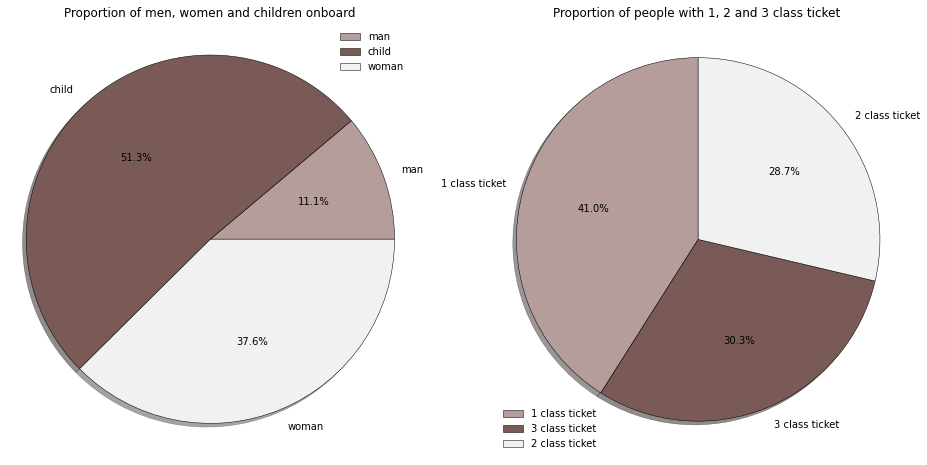

The first chart shows that majority (51.3%) of people onboard are children under 16 years old.
The second chart shows that majority (41%) of people onboard have ticket of 1 class


In [35]:
# Create pie charts with showing proportion of people onboard and proportion of ticket classes they have

figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))
colors = ['#b59d9b', '#7a5a56', '#f1f1f1']
ax1.pie(dataset.groupby('Category')['Category'].count(), labels = dataset['Category'].unique(), colors = colors,
                        autopct='%1.1f%%', shadow=True, wedgeprops = {"linewidth": 0.5, "edgecolor": "#000000"})
ax1.axis('equal') 
ax1.set_title("Proportion of men, women and children onboard")
ax1.legend(frameon = False)
labels = [str(x) + ' class ticket' for x in dataset['Ticket class'].unique()]
ax2.pie(dataset['Ticket class'].value_counts(), labels = labels, colors = colors, autopct='%1.1f%%', shadow=True, 
        wedgeprops = {"linewidth": 0.5, "edgecolor": "#000000"}, startangle = 90)
ax2.axis('equal') 
ax2.set_title("Proportion of people with 1, 2 and 3 class ticket")
ax2.legend(frameon = False)
plt.show()

print('The first chart shows that majority (51.3%) of people onboard are children under 16 years old.')
print('The second chart shows that majority (41%) of people onboard have ticket of 1 class')

In [36]:
# Determine avarege prices for ticket of each class. These information can be used to fill gaps in 'Fare' column of the dataset

class_fare = dataset.groupby(['Ticket class'])['Fare'].mean()

In [37]:
# Fill the 'Fare' column of the dataset with mean price of the ticket according to the ticket class

dataset['Fare'] = dataset.apply((lambda df: class_fare.loc[df['Ticket class']]
                                               if pd.isnull(df['Fare']) else df['Fare']), axis = 1)

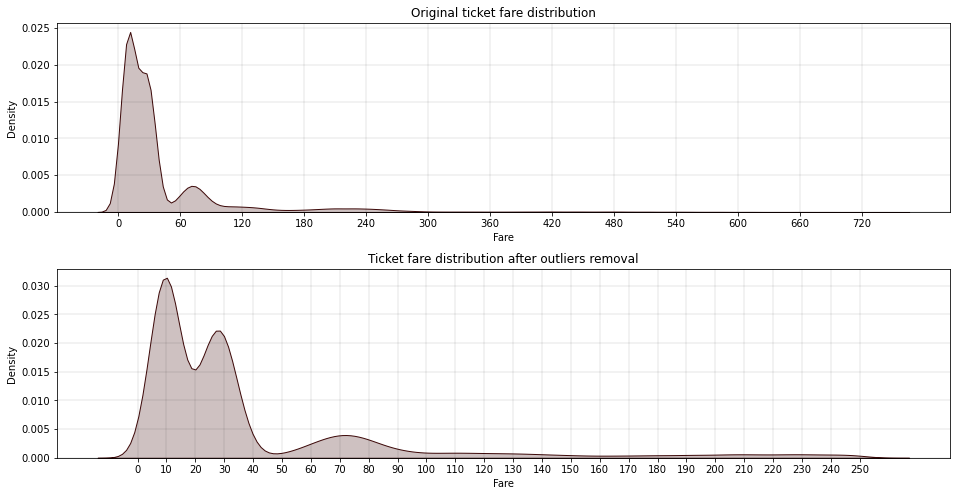

In [38]:
# Display ticket fare distribution

figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (16, 8))
figure.subplots_adjust(hspace = 0.3)  

ax1.set_title('Original ticket fare distribution')
sns.kdeplot(data = dataset['Fare'], color = '#3d0909', shade=True, ax = ax1)
ax1.grid(which = 'both', axis = 'both', linewidth = 0.1, color = "#000000")
ax1.set_xticks(np.arange(int(dataset['Fare'].min()), int(dataset['Fare'].max()), 60))

# Replace the outliers in the 'Fare' column of the dataset

mean = dataset['Fare'].mean()
std = dataset['Fare'].std()
dataset['Fare'] = dataset.apply((lambda df: random.randrange(int(mean), int(mean + 3 * std)) 
                                 if (df['Fare'] > (mean + 3 * std)) else df['Fare']), axis = 1)

# Display ticket fare distribution after outliers removal

ax2.set_title('Ticket fare distribution after outliers removal')
sns.kdeplot(data = dataset['Fare'], color = '#3d0909', shade=True, ax = ax2)
ax2.grid(which = 'both', axis = 'both', linewidth = 0.1, color = "#000000")
ax2.set_xticks(np.arange(int(dataset['Fare'].min()), int(dataset['Fare'].max()), 10))
plt.show()

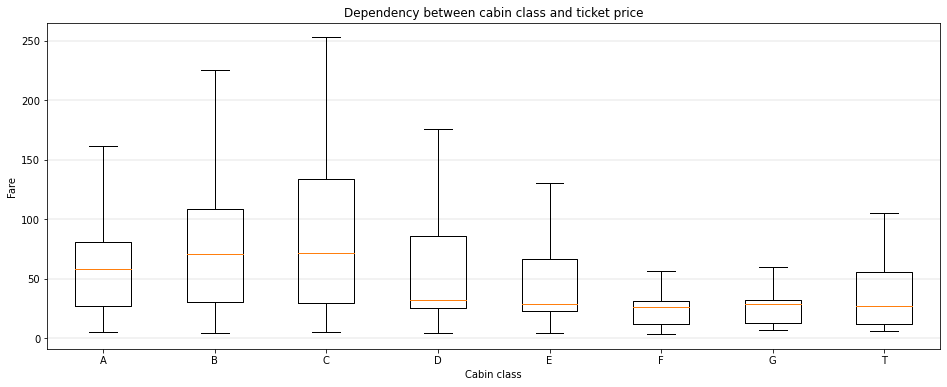

The graph shows that there is no strong dependency between ticket price and cabin class.
However, it can be noted that roughly the worse the cabin class the lower mean ticket price.


In [39]:
# Check if there is dependency between cabin class and ticket price

unique_class = dataset['Cabin class'].unique().tolist()
unique_class.pop(1)
unique_class.sort()
cabin_class = []
label = []

for i in range(len(unique_class)):
    label.append(unique_class[i])
    cabin_class.append(dataset[dataset['Cabin class'] == unique_class[i]]['Fare'].values)
        
plt.figure(figsize = (16, 6))
plt.grid(axis = 'y', linewidth = 0.1, color = "#000000")
plt.title('Dependency between cabin class and ticket price')  
plt.boxplot(cabin_class, showfliers=False)
plt.ylabel('Fare')
plt.xlabel('Cabin class')
plt.xticks(np.arange(1, 9), label)
plt.show()

print('The graph shows that there is no strong dependency between ticket price and cabin class.')
print('However, it can be noted that roughly the worse the cabin class the lower mean ticket price.')

In [45]:
# Fill missing values of Cabin class and Embarked variables 

dataset['Cabin class'].fillna(random.choice(label), inplace = True)
dataset['Embarked'].fillna(dataset['Embarked'].value_counts().index[0], inplace = True)

# Fill missing values of Cabin number

dataset['Cabin number'].fillna(random.randint(0, 20000), inplace = True)
dataset['Cabin number'] = dataset['Cabin number'].astype('int64')

dataset['Ticket'].fillna(random.randint(0, 80000), inplace = True)

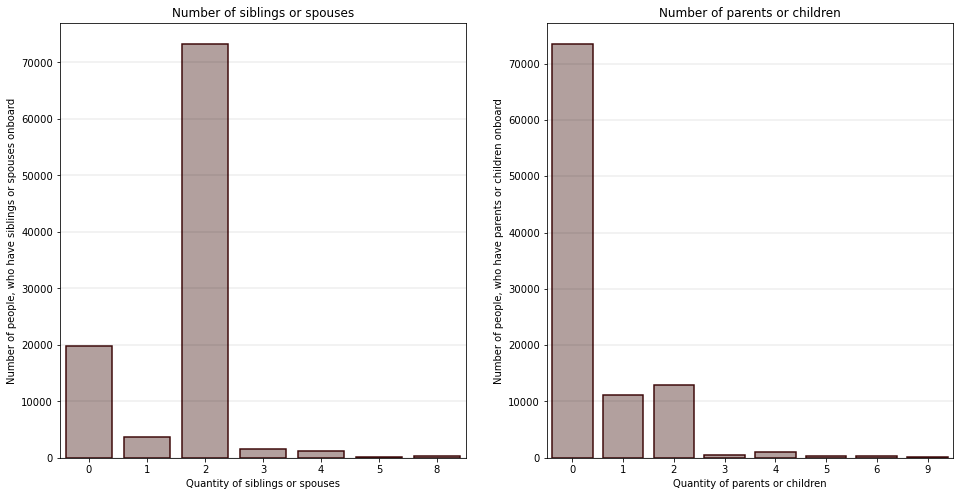

The first plot reveals that most of the passengers traveled together with siblings or spouses.
However, the majority of the people onboard didn't take along their parents or children based on the second plot.


In [46]:
# Render the number of siblings/spouses and parents/children onboard

figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))
ax1.set_title('Number of siblings or spouses')
ax1.grid(linewidth = 0.1, color = "#000000")
sns.barplot(x = dataset['Siblings/spouses'].unique(), y = dataset['Siblings/spouses'].value_counts(), 
            linewidth = 1.5, color = '#b59d9b', edgecolor='#3d0909', ax = ax1)
ax1.set_xlabel('Quantity of siblings or spouses')
ax1.set_ylabel('Number of people, who have siblings or spouses onboard')
ax2.set_title('Number of parents or children')
ax2.grid(linewidth = 0.1, color = "#000000")
sns.barplot(x = dataset['Parents/children'].unique(), y = dataset['Parents/children'].value_counts(), 
            linewidth = 1.5, color = '#b59d9b', edgecolor='#3d0909', ax = ax2)
ax2.set_xlabel('Quantity of parents or children')
ax2.set_ylabel('Number of people, who have parents or children onboard')
plt.show()

print('The first plot reveals that most of the passengers traveled together with siblings or spouses.')
print('However, the majority of the people onboard didn\'t take along their parents or children based on the second plot.')

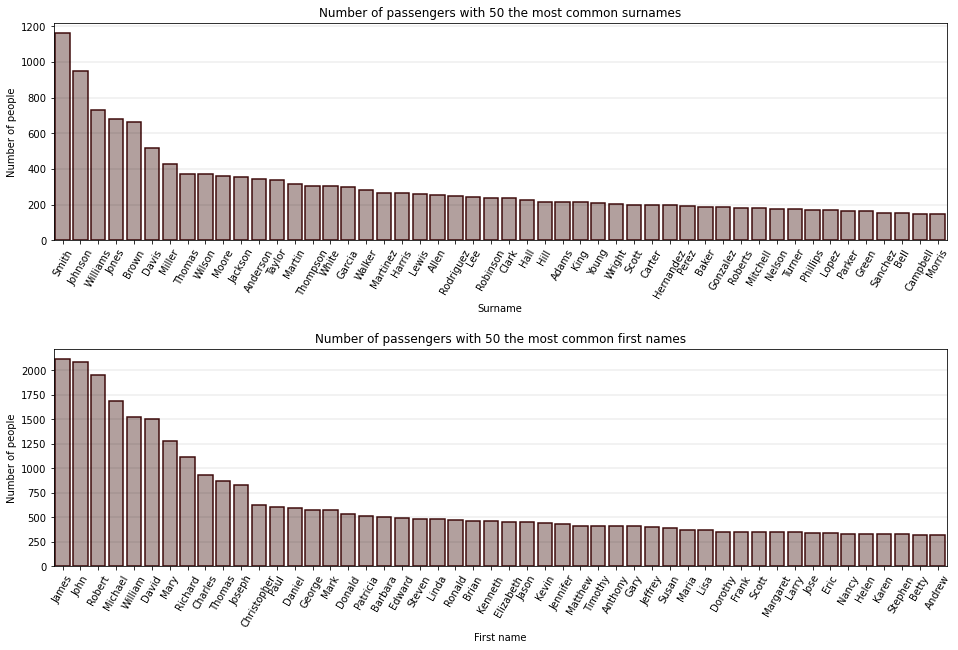

The graphs reveals that the most common surname is Smith, whereas, the most common first name is James


In [48]:
# Determine 50 the most common surnames and names of the people onboard 

figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (16, 10))
figure.subplots_adjust(hspace = 0.5)  

ax1.grid(linewidth = 0.1, color = "#000000")
ax1.set_title('Number of passengers with 50 the most common surnames')
sns.barplot(x = dataset['Surname'].value_counts()[:50].index, y = dataset['Surname'].value_counts()[:50], 
            linewidth = 1.5, color = '#b59d9b', edgecolor='#3d0909', ax = ax1)
ax1.tick_params(axis = 'x', labelrotation = 60)
ax1.set_ylabel('Number of people')
ax1.set_xlabel('Surname')

ax2.grid(linewidth = 0.1, color = "#000000")
ax2.set_title('Number of passengers with 50 the most common first names')
sns.barplot(x = dataset['First name'].value_counts()[:50].index, y = dataset['First name'].value_counts()[:50], 
            linewidth = 1.5, color = '#b59d9b', edgecolor='#3d0909', ax = ax2)
ax2.tick_params(axis = 'x', labelrotation = 60)
ax2.set_ylabel('Number of people')
ax2.set_xlabel('First name')
plt.show()

print('The graphs reveals that the most common surname is Smith, whereas, the most common first name is James')

In [85]:
# Examine influence of varios factors on the chance to survive on Titanic

print('Number of passengers survived is {}, whereas number of passengers dead is {}.'
      .format(dataset['Survived'].value_counts()[1], dataset['Survived'].value_counts()[0]))
print('Thus, there were more people, who didn\'t managed to survive in the accident than who did.')

Number of passengers survived is 42774, whereas number of passengers dead is 57226.
Thus, there were more people, who didn't managed to survive in the accident than who did.


In [50]:
# Render non-numeric part after dataset processing

non_numeric_data = dataset.select_dtypes(include = ['object']).join(dataset[['Ticket class', 'Survived', 'Sex', 
                                                                             'Embarked', 'Cabin class']])

unique_n = non_numeric_data.apply(lambda col: len(col.unique()))

instances_n = 9
instances = non_numeric_data.apply(lambda col: col.unique().tolist() if len(col.unique()) <= instances_n 
                                   else random.choices(col.unique(), k = 5))

nan_n = non_numeric_data.apply(lambda col: col.isna().sum())

non_numeric_info = pd.DataFrame({'Number of unique values': unique_n, 'Instances of vabiable': instances, 
                                 'Number of nan values': nan_n})

styler3 = non_numeric_info.style
styler3.set_caption('Information on non-numeric data of the Titanic dataset - Raw data')
styler3.set_table_styles(styling_tables)

,Number of unique values,Instances of vabiable,Number of nan values
Ticket,75332,"['407969', '431176', '3739892', '39910', 'PC 17419']",0
First name,3953,"['Tristan', 'Myung', 'Dick', 'Barbara', 'Isobel']",0
Surname,21558,"['Whittingham', 'Dodgen', 'Shorts', 'Brassard', 'Veenstra']",0
Ticket class,3,"[1, 3, 2]",0
Survived,2,"[1, 0]",0
Sex,2,"['male', 'female']",0
Embarked,3,"['S', 'C', 'Q']",0
Cabin class,8,"['C', 'E', 'A', 'D', 'B', 'F', 'G', 'T']",0


In [57]:
# Render numeric part after dataset processing

numeric_data = dataset.select_dtypes(include = ['int64', 'float64'])
maximum = numeric_data.apply(lambda col: col.max())
minimum = numeric_data.apply(lambda col: col.min())
mean = numeric_data.apply(lambda col: col.mean())
std = numeric_data.apply(lambda col: col.std())
nan_n = numeric_data.apply(lambda col: col.isna().sum())

outlier_n = []
for i in range(numeric_data.shape[1]):
    outlier_n.append(len(numeric_data[numeric_data.iloc[:, i] < (mean[i] - 3 * std[i])]) 
                    + len(numeric_data[numeric_data.iloc[:, i] > (mean[i] + 3 * std[i])]))

numeric_info = pd.DataFrame({'Minimum value': minimum, 'Maximum value': maximum, 'Mean value': mean, 'Standad deviation': std,
                            'Number of nan values': nan_n, 'Number of outliers': outlier_n})

styler4 = numeric_info.style
styler4.set_caption('Information on numeric data of the Titanic dataset - Processed data')
styler4.set_table_styles(styling_tables)

,Minimum value,Maximum value,Mean value,Standad deviation,Number of nan values,Number of outliers
Age,0.000000,87.000000,38.008850,18.110736,0,0
Siblings/spouses,0.000000,8.000000,0.397690,0.862566,0,3231
Parents/children,0.000000,9.000000,0.454560,0.950076,0,1245
Fare,0.680000,252.570000,38.693805,48.510187,0,3872
Cabin number,1087.000000,23978.000000,13686.201830,3344.247856,0,1733
